In [50]:
# use gymnasium gym-anytrading stable-baselines3
!pip install gymnasium gym-anytrading stable-baselines3

Data AAPL.csv contains historical prices for AAPL.
Description of the data:


Column	- Description
, Date	- The date corresponding to the closing price
, Close	- The closing price of the security on the given date

In [51]:
# Import required packages
# gym-anytrading is a gym environment specific for trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold


# data provided
data = pd.read_csv("AAPL.csv", parse_dates=True, index_col='Date')

#  window size (lookback window), start and end index of data
window_size = 10
start_index = window_size
end_index = len(data)



In [52]:
data.head()

,Close
Date,
2009-07-09,4.870000
2009-07-10,4.947143
2009-07-13,5.083571
2009-07-14,5.081071
2009-07-15,5.245714


In [53]:
# Environment using the pre-built 'stocks-v0', passing in the data loaded above
# window_size-> is how far the environment can look back at each step
# frame_bound -> is the bounding box of the environment, the size of our data
env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("Observation Space:", env.observation_space)

# Initialise cash balance tracking and other variables
balance = 100000 # initial cash balance of the agent is set to 100,000 units 
balance_history = [balance] #keeps track of the agent's cash balance over time.
shares_held = 0 #racks the number of shares currently held by the agent.
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset(seed=2024)

Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [54]:

# Wrapping the environment in a DummyVecEnv to support vectorized environments (required for stable-baselines3)
env = DummyVecEnv([lambda: env])


In [55]:
# Define the PPO model
model = PPO("MlpPolicy", env, verbose=1) 


Using cpu device


Callbacks can help in saving the model at certain intervals, evaluating performance, or stopping training when certain conditions are met.

In [56]:
# Stop training once a certain reward threshold is achieved
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=50000, verbose=1)

# Evaluation callback to monitor the agent's performance during training
eval_callback = EvalCallback(env, 
                             best_model_save_path='./logs/',
                             log_path='./logs/',
                             eval_freq=5000,
                             deterministic=True, 
                             render=False,
                             callback_on_new_best=stop_callback)


In [57]:
# Train the model
model.learn(total_timesteps=100000, callback=eval_callback)


-----------------------------
| time/              |      |
|    fps             | 5665 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3103        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018212065 |
|    clip_fraction        | 0.0388      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | -0.00365    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.219       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00183    |
|    value_loss           | 0.52        |
-----------------------------------------


/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00
Episode length: 3763.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 3.76e+03     |
|    mean_reward          | 0            |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0004800388 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.68        |
|    explained_variance   | 0.00192      |
|    learning_rate        | 0.0003       |
|    loss                 | 4.16         |
|    n_updates            | 20           |
|    policy_gradient_loss | -1.7e-05     |
|    value_loss           | 13.3         |
------------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 1482 |
|    iterations      | 3   

In [58]:
# Save the trained model
model.save("ppo_stock_trading")


## Test

In [59]:
# Load the trained model to check loading
model = PPO.load("ppo_stock_trading")

# Testing
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    #env.render()


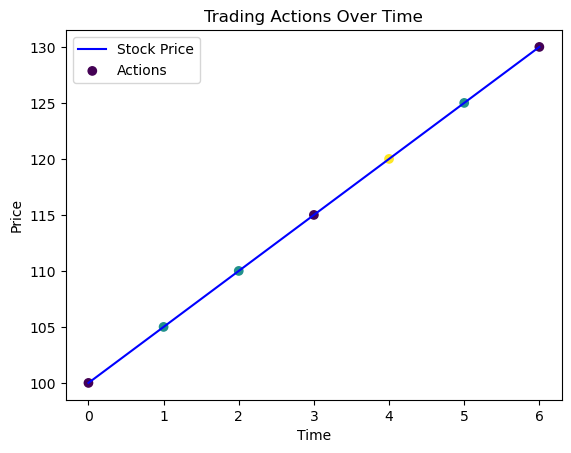

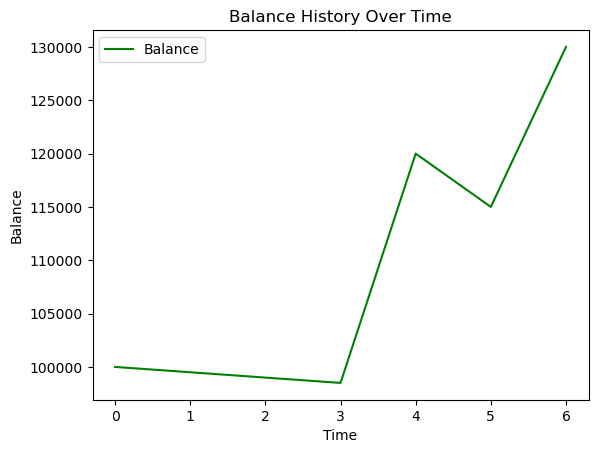

In [60]:
import matplotlib.pyplot as plt

# Example data
actions = [0, 1, 1, 0, 2, 1, 0]  # Sample actions: 0=Hold, 1=Buy, 2=Sell
prices = [100, 105, 110, 115, 120, 125, 130]  # Sample stock prices over time
balance_history = [100000, 99500, 99000, 98500, 120000, 115000, 130000]  # Sample balance history

#  Plot showing trading actions
fig, ax = plt.subplots()
ax.plot(prices, label='Stock Price', color='blue')
ax.scatter(range(len(actions)), prices, c=actions, cmap='viridis', label='Actions', marker='o')
ax.set_title('Trading Actions Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()

#  Plot of the balance_history over time
fig2, ax2 = plt.subplots()
ax2.plot(balance_history, label='Balance', color='green')
ax2.set_title('Balance History Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Balance')
ax2.legend()

plt.show()
